## Feature Selection

This '.ipynb' file contains some agressive feature selection to reduce the total of a litte over 32000 features down to a manageble count valuable for training. This wil be done trough various methods:

- Inital feature selection of clinical data
- Dropping duplicates
- Dropping NaN values
- Mixed Data types
- Fracting thresholding
- Variance thresholding
- Correlation thresholding
- Lasso regression
- KBest selection
- More...

By aplying al of these feature reducing methods whe hope to reduce the total feature count to a maximun of a couple honderd to a thousend features.

#### 1. Understanding the dataset
The preprocessed dataset is loaded in, and two small functions are defined to retrieve the clinical and gene columns respectably. Some general information is printed to the screen to get a general sense of the scale and size op de dataset. Next to this a small graph is plotted to view the distribution of the histology types.

Gene columns (33764): ['LINC01587_unstranded', 'AC000061.1_unstranded', 'AC016026.1_unstranded', 'IGF2-AS_unstranded', 'RRN3P2_unstranded', 'AC087235.1_unstranded', 'DLEU2L_unstranded', 'PINK1-AS_unstranded', 'SPART-AS1_unstranded', 'LINC00544_unstranded', 'KIAA0087_unstranded', 'AC105760.1_unstranded', 'MYRF-AS1_unstranded', 'MIR9-1HG_unstranded', 'LINC00029_unstranded', 'FAM182A_unstranded', 'LINC02871_unstranded', 'C22orf24_unstranded', 'TTTY1B_unstranded', 'TTTY1_unstranded', 'H19_unstranded', 'TTTY9B_unstranded', 'AC091132.1_unstranded', 'TTTY6_unstranded', 'TTTY6B_unstranded', 'LINC00470_unstranded', 'AL139352.1_unstranded', 'C7orf69_unstranded', 'AL355922.1_unstranded', 'AC027088.1_unstranded', 'AC062028.1_unstranded', 'CCDC39_unstranded', 'LINC01558_unstranded', 'LINC00525_unstranded', 'TTTY7_unstranded', 'TTTY7B_unstranded', 'SCP2D1-AS1_unstranded', 'LINC00266-1_unstranded', 'AL136982.1_unstranded', 'PART1_unstranded', 'LINC00467_unstranded', 'ZFHX2-AS1_unstranded', 'TUBA3FP_u

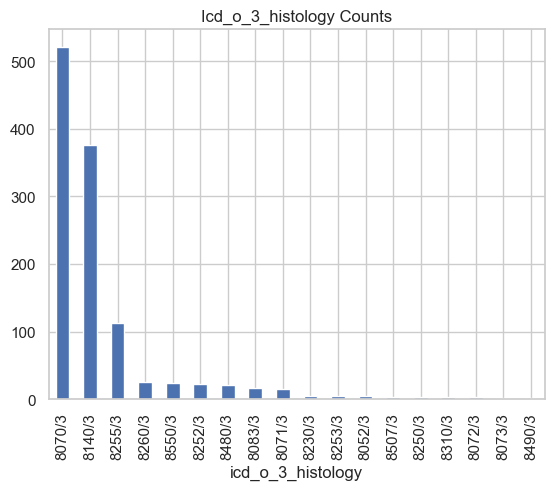

In [3283]:
import pandas as pd

# Loading the preprocessed dataset
dataFrame: pd.DataFrame = pd.read_csv('./DatasetParser/Dataset/ProcessedFiles/merged_data.csv', low_memory=False)

# Filtering the feature columns by a specific prefix to isolate gene expression data
def getGeneColumns() -> list[str]:
    return [col for col in dataFrame.columns if 'unstranded' in col]

# Al the non-gene columns are considered clinical columns
def getClinicalColumns() -> list[str]:
    geneColumns: set[str] = set(getGeneColumns())
    return [col for col in dataFrame.columns if col not in geneColumns]

# Defining the two different types of feature columns
geneColumns: list[str] = getGeneColumns()
allClinicalColumns: list[str] = getClinicalColumns()

# Displaying gene, clinical and total column counts
print(f"Gene columns ({len(geneColumns)}): {geneColumns}")
print(f"Clinical columns ({len(allClinicalColumns)}): {allClinicalColumns}")
print(f"Total columns in the dataset: {len(dataFrame.columns)}")

# Displaying the row count of the dataset
print(f"\nTotal rows in the dataset: {len(dataFrame)}")

# The target feature for model evaluation
targetColumn: str = 'icd_o_3_histology'

# Defining the clinical columns to be retained
clinicalColumns: list[str] = [targetColumn]

# Defining a combined list of features that represent the whole dataset
selectedColumns: list[str] = clinicalColumns + geneColumns

# Plotting the training target column count distribution in graph format
histologyCounts = dataFrame[targetColumn].value_counts()
histologyCounts.plot(kind='bar', title=f'{targetColumn.capitalize()} Counts')

# Displating the distribution using text format for precision
print(f"\n{targetColumn.capitalize()} Counts Distribution:")
print(histologyCounts)


#### 2. NaN, Duplicates, Mixed data types

First the preprocessed dataset is checked for duplicates based on the "case_id", only one row should be availible for each case. Next any rows containing NaN values are dropped. Lastly the gene features are checked for mixed data types. Any rows with mixed data types wil be removed. These step together make sure that the ML models have a proper format for train with.

In [3284]:
# Saving the orginal dataset size, before it changes
oldRowCount: int = len(dataFrame)

# Dropping al the duplicate rows based on the 'case_id' column, to ensure each case is unique
dataFrame.drop_duplicates(subset=['case_id'], inplace=True)

# Only keeping the selected columns, this is done after dropping duplicates else the 'case_id' column would not exist
dataFrame = dataFrame[selectedColumns]

# Calculating the difference between the old and new count to retieve the number of duplicate rows
duplicateRowCount: int = oldRowCount - len(dataFrame)

# Dropping rows with any NaN values
dataFrame.dropna(inplace=True)

# Calculating the difference between the old and new count to retieve the number of NaN rows
nanRowCount: int = oldRowCount - duplicateRowCount - len(dataFrame)

# Identifying columns with mixed data types
mixedTypeColumns: list[str] = [
    col for col in dataFrame.columns
    if dataFrame[col].map(type).nunique() > 1
]

# Dropping columns with mixed data types
dataFrame.drop(columns=mixedTypeColumns, inplace=True)

# Keeping the gene columns up-to-date
geneColumns = getGeneColumns()

# Calculating the difference between the old and new count to retieve the number of mixed type rows
mixedTypeRowCount: int = oldRowCount - duplicateRowCount - nanRowCount - len(dataFrame)

# Retrieving the final row count after all operations
newRowCount: int = len(dataFrame)

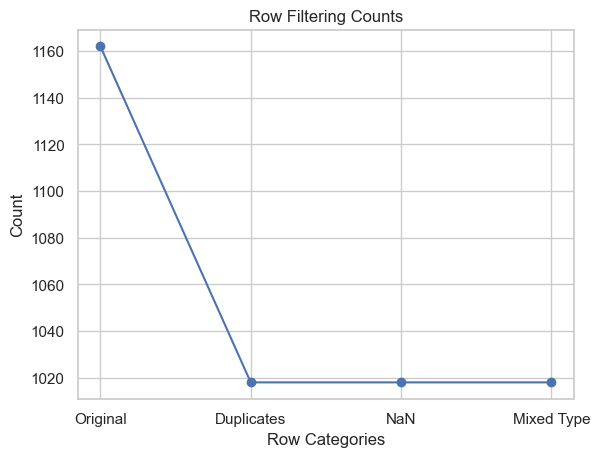

Original row count: 1162
Duplicate rows removed: 144
Rows with NaN values removed: 0
Mixed type rows removed: 0
Final row count after processing: 1018


In [3285]:
import matplotlib.pyplot as plt

# Plotting keys and values for the line graph
categories = ['Original', 'Duplicates', 'NaN', 'Mixed Type']
counts = [oldRowCount, duplicateRowCount, nanRowCount, mixedTypeRowCount]

# Updating the changes in count to refect total counts
current = oldRowCount
for i, count in enumerate(counts[1:]):
    current -= count
    counts[i + 1] = current

plt.plot(categories, counts, marker='o', linestyle='-', color='b')  # line with points
plt.title('Row Filtering Counts')
plt.xlabel('Row Categories')
plt.ylabel('Count')
plt.grid(True)  # optional, adds grid for readability
plt.show()

# Displaying the statsistics in text format for precise values
print(f"Original row count: {oldRowCount}")
print(f"Duplicate rows removed: {duplicateRowCount}")
print(f"Rows with NaN values removed: {nanRowCount}")
print(f"Mixed type rows removed: {mixedTypeRowCount}")
print(f"Final row count after processing: {newRowCount}")

#### 3. Categorising the histology types

In [ ]:
# Initializing the histology column to classify histology types
dataFrame[targetColumn] = dataFrame[targetColumn].astype(str)

# Mapping the category numbers to their respective names for visualization
categoryNameMap: dict[int, str] = {
    0: 'Squamous',
    1: 'Adenocarcinoma',
    2: 'Other'
}   

# Defining sets to identify histology types in each category
squamousCodes: set = set()
adenocarcinomaCodes: set = set()
otherHistologyCodes: set = set()
invalidHistologyCodes: set = set()

# Function looks at the ICD-O-3 histology code and classifies it into one of three categories
def classifyHistology(icdCode: str) -> int:
    global otherHistologyCodes, squamousCodes, adenocarcinomaCodes, invalidHistologyCodes

    try:
        # Retrieving the numerical main code from the ICD-O-3 histology code
        mainCode: int = int(icdCode.split("/")[0])
    except:
        invalidHistologyCodes.add(icdCode)
        return None
    # Squamous
    if  8050 <= mainCode <= 8084:
        squamousCodes.add(icdCode)
        return 0
    # Adenocarcinoma  
    elif 8140 <= mainCode <= 8576:
        adenocarcinomaCodes.add(icdCode)
        return 1 
    
    # Other histology types will be counted as 2 ("Other")
    otherHistologyCodes.add(icdCode)
    return 2

# Dropping possible invalid histology codes
dataFrame.dropna(subset=[targetColumn], inplace=True)

# Classifying histology types and updating the histology column
dataFrame[targetColumn] = dataFrame[targetColumn].apply(classifyHistology).astype("category")

# Displaying the unique histology types and their counts
print(f'Squamous Codes ({len(squamousCodes)}):', squamousCodes)
print(f'Adenocarcinoma Codes ({len(adenocarcinomaCodes)}):', adenocarcinomaCodes)
print(f'Other Histology Codes ({len(otherHistologyCodes)}):', otherHistologyCodes)
print(f'Invalid Histology Codes ({len(invalidHistologyCodes)}):', invalidHistologyCodes)

Squamous Codes (6): {'8052/3', '8072/3', '8070/3', '8073/3', '8083/3', '8071/3'}
Adenocarcinoma Codes (12): {'8255/3', '8507/3', '8252/3', '8480/3', '8490/3', '8310/3', '8550/3', '8140/3', '8253/3', '8230/3', '8250/3', '8260/3'}
Other Histology Codes (0): set()
Invalid Histology Codes (0): set()


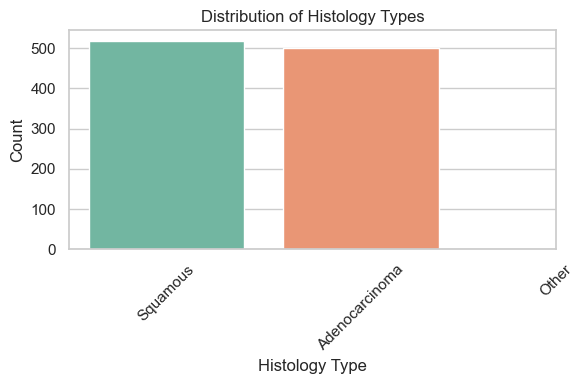

Squamous Count: 500
Adenocarcinoma Count: 518
Other Histology Count: 0


In [3287]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting a small graph to visualize the distribution of histology types
sns.set_theme(style="whitegrid")
plt.figure(figsize=(6, 4))
sns.countplot(x=dataFrame[targetColumn].astype(str), palette="Set2", hue=dataFrame[targetColumn].astype(str))
plt.title('Distribution of Histology Types')
plt.xlabel('Histology Type')
plt.ylabel('Count')
plt.xticks(ticks=list(categoryNameMap.keys()), labels=list(categoryNameMap.values()), rotation=45)
plt.tight_layout()
plt.show()

# Displaying the distribution of histology in text format to ensure precision
print('Squamous Count:', dataFrame[targetColumn].value_counts().get(0, 0))
print('Adenocarcinoma Count:', dataFrame[targetColumn].value_counts().get(1, 0))
print('Other Histology Count:', dataFrame[targetColumn].value_counts().get(2, 0))

### 4. Fraction Threshold

Any genes that where 80% of the sampels have a value lower that 80% wil be dropped, these genes likely do not play a large role in detecting histology subtypes.

In [ ]:
# A dictionary to map the feature selection steps to data frame feature counts
featureSelectionSteps: dict[str, int] = {"Initial": len(dataFrame.columns)}

countThreshold: int = 5 # TODO find logical value
sampleFractionThreshold: float = 0.8 # TODO find logical value

# Creating a mask for the data frame so only the active genes are included
lowCountmask = (dataFrame[geneColumns] < countThreshold).sum(axis=0) > (sampleFractionThreshold * dataFrame[geneColumns].shape[0])

# Creating a filterd data frame containing onlt gene columns that meet the threshold criteria
filteredDataFrame: pd.DataFrame = dataFrame[geneColumns].loc[:, ~lowCountmask]

# Updating the gene columns to ensure correct indexing
geneColumns = filteredDataFrame.columns

# Joining the original clinical columns with the filtered gene columns
dataFrame = dataFrame[clinicalColumns].join(filteredDataFrame)

# Adding an entry to the feature selection steps dictionary
featureSelectionSteps["Fraction Threshold"] = len(dataFrame.columns)

#### 5. Variance threshold

Small variance between gene samples have litte to no value to the global model training and can be dropped.

In [3289]:
from numpy import ndarray
from sklearn.feature_selection import VarianceThreshold

# Define a threshold for variance
varianceThreshold: int = 15  # TODO find logical value

# Step 1: Creating the data frame for the variance threshold to be applied
threshHoldDataFrame: pd.DataFrame = dataFrame[geneColumns]

# Step 2: Appling the VarianceThreshold
selector = VarianceThreshold(threshold=varianceThreshold)
selector.fit(threshHoldDataFrame)

# Step 3: Get selected column names
geneColumns = threshHoldDataFrame.columns[selector.get_support()]

# Step 4: Updating the data frame with the selected feature columns joined with clinical columns
dataFrame = threshHoldDataFrame[geneColumns].join(dataFrame[clinicalColumns])

# Adding an entry to the feature selection steps dictionary
featureSelectionSteps["Variance Threshold"] = len(dataFrame.columns)

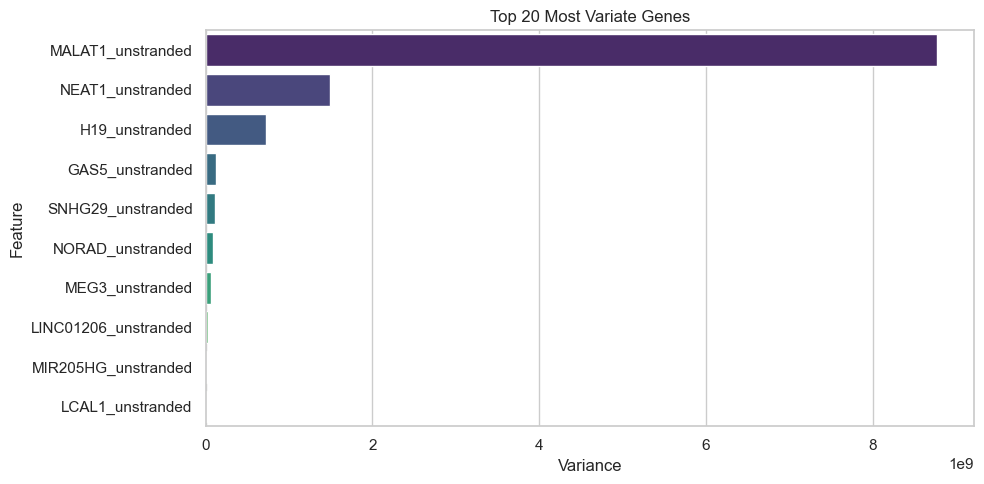

In [3290]:
# Retrieving the 10 most variate genes for visualization
plotX = threshHoldDataFrame[geneColumns].var().sort_values(ascending=False)[:10]

# Plotting the most variate genes to visualize the variance distribution
plt.figure(figsize=(10, 5))
sns.barplot(x=plotX.values, 
    y=plotX.index, palette='viridis', hue=plotX.index, dodge=False)
plt.title('Top 20 Most Variate Genes')
plt.xlabel('Variance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

#### 6. Standard scaler (Data split)

In [3291]:
from sklearn.preprocessing import StandardScaler

# Splits the DataFrame into features (X) and target (y).
def getDataXAndY(dataFrame: pd.DataFrame, targetColumn: str) -> tuple[pd.DataFrame, pd.Series]:
    # All features except the target
    X = dataFrame.drop(columns=[targetColumn]) 
    # Target variable 
    y = dataFrame[targetColumn]  
    return X, y

X, y = getDataXAndY(dataFrame, targetColumn)

# Scale the features (Lasso is sensitive to scale)
xScaled: ndarray = StandardScaler().fit_transform(X)

# Applying the scaling to the DataFrame
dataFrame[geneColumns] = xScaled

#### 7. Lasso regression

In [3292]:
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel

# Define a threshold for Lasso regularization
lassoThreshold: float = 0.01  # TODO find logical value

X, y = getDataXAndY(dataFrame, targetColumn)

# 1. Fit Lasso and SelectFromModel
lasso: Lasso = Lasso(alpha=lassoThreshold)
selector: SelectFromModel = SelectFromModel(lasso)
selector.fit(X, y)

# 2. Get selected feature mask
lowCountmask: ndarray = selector.get_support()

# 3. Use mask to trim original DataFrame (preserving column names)
geneColumns = X.columns[lowCountmask]

# 4. join the target column with the filtered gene columns
dataFrame = X[geneColumns].join(y)

# Adding an entry to the feature selection steps dictionary
featureSelectionSteps["Lasso Threshold"] = len(dataFrame.columns)

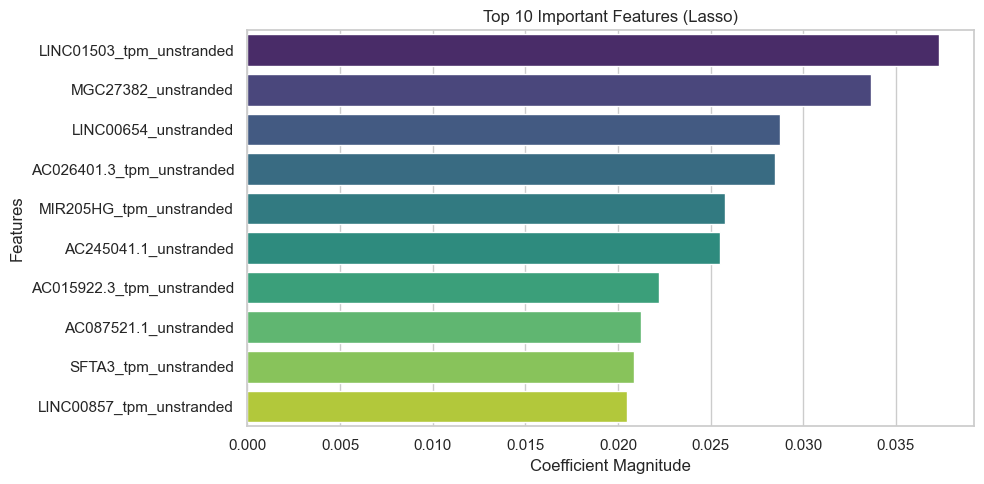

In [3293]:
# Plotting the 10 best features based on Lasso coefficients
import matplotlib.pyplot as plt
import numpy as np

# Use real column names from your DataFrame
featureNames: list[str] = X.columns.tolist()

# Absolute coefficients
coefs = np.abs(selector.estimator_.coef_)

# Get indices of top 10 features
topIndices = np.argsort(coefs)[-10:][::-1] 

# Storing the plot y for the plot data and hue
plotX = np.array(featureNames)[topIndices]

# Plot the coefficients of the top 10 features
plt.figure(figsize=(10, 5))
sns.barplot(x=coefs[topIndices], y=plotX,  palette='viridis', hue=plotX, dodge=False)
plt.xlabel("Coefficient Magnitude")
plt.ylabel("Features")
plt.title("Top 10 Important Features (Lasso)")
plt.tight_layout()
plt.show()

#### 8. Correlation threshold

Any correlated features have litte to no extra value to be includeded in model training and can be dropped.

In [3294]:
# Defining a threshold for correlation
correlationThreshold: float = 0.75 

# Creating a correlation matrix
correlationMatrix: pd.DataFrame = dataFrame[geneColumns].corr()

# Finding pairs of columns with correlation above the threshold
selectedColumns = set()
for i in range(len(correlationMatrix.columns)):
    for j in range(i):
        if abs(correlationMatrix.iloc[i, j]) > correlationThreshold:
            colname: str = correlationMatrix.columns[i]
            selectedColumns.add(colname)

# Dropping the selected columns from the original DataFrame
dataFrame.drop(columns=selectedColumns, inplace=True)

# Updating the geneColumns to reflect the reduced set after correlation thresholding
geneColumns = getGeneColumns()

# Adding an entry to the feature selection steps dictionary
featureSelectionSteps["Correlation Threshold"] = len(dataFrame.columns)

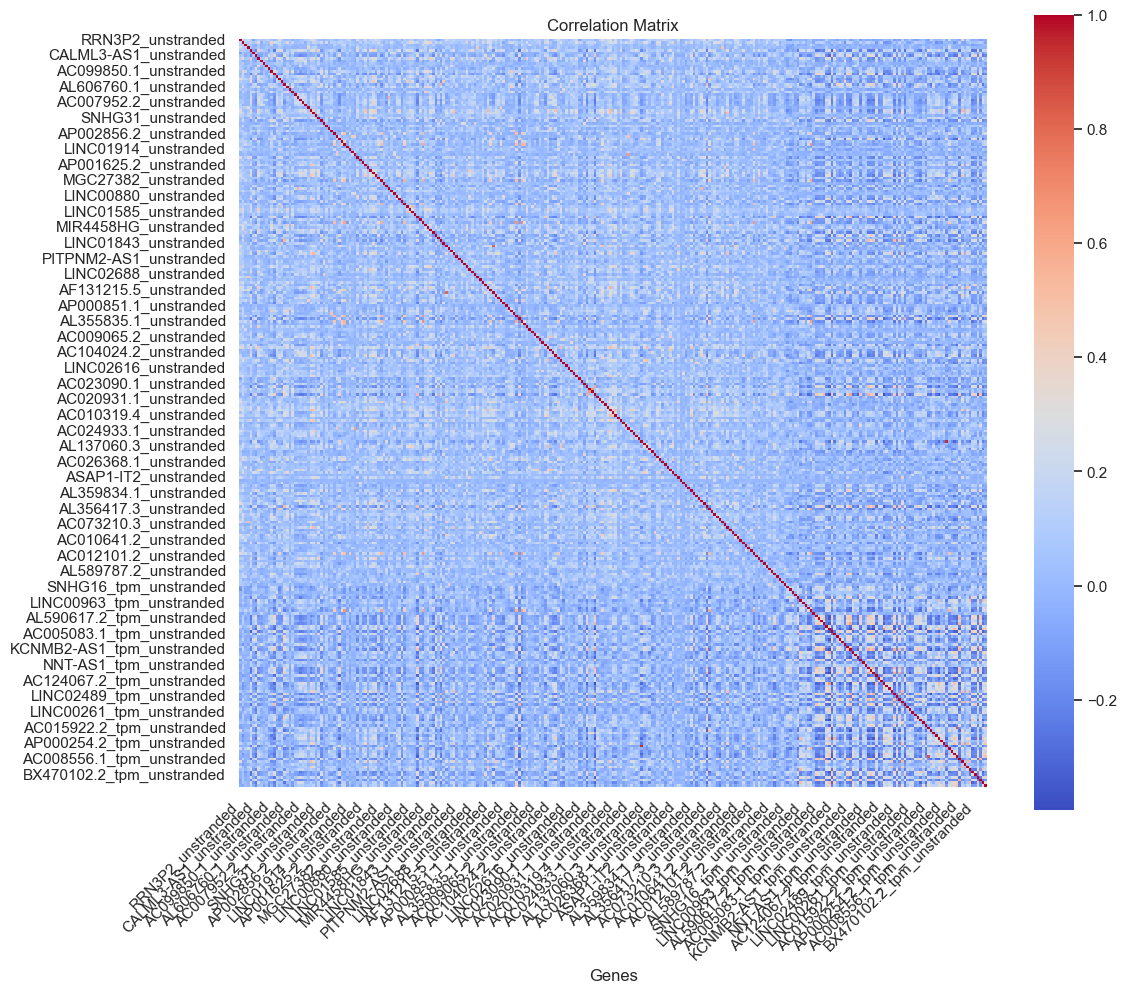

In [3295]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plotting the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlationMatrix, annot=False, fmt=".2f", cmap='coolwarm', square=True)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.xlabel('Genes')
plt.title('Correlation Matrix')
plt.show()

#### 9. Select K Best

In [3296]:
from numpy import ndarray
from sklearn.feature_selection import SelectKBest, f_classif

kSelectBestThreshold: int = 10  # TODO find logical value

X, y = getDataXAndY(dataFrame, targetColumn)

# Creating the SelectKBest selector with the given threshold goal
selector: SelectKBest = SelectKBest(score_func=f_classif, k=kSelectBestThreshold)
selector.fit(X, y)

# Getting the mask of selected features
lowCountmask: ndarray = selector.get_support()
geneColumns = X.columns[lowCountmask]

# join the target column back
dataFrame = X[geneColumns].join(y)

# Adding an entry to the feature selection steps dictionary
featureSelectionSteps["SelectKBest"] = len(dataFrame.columns)

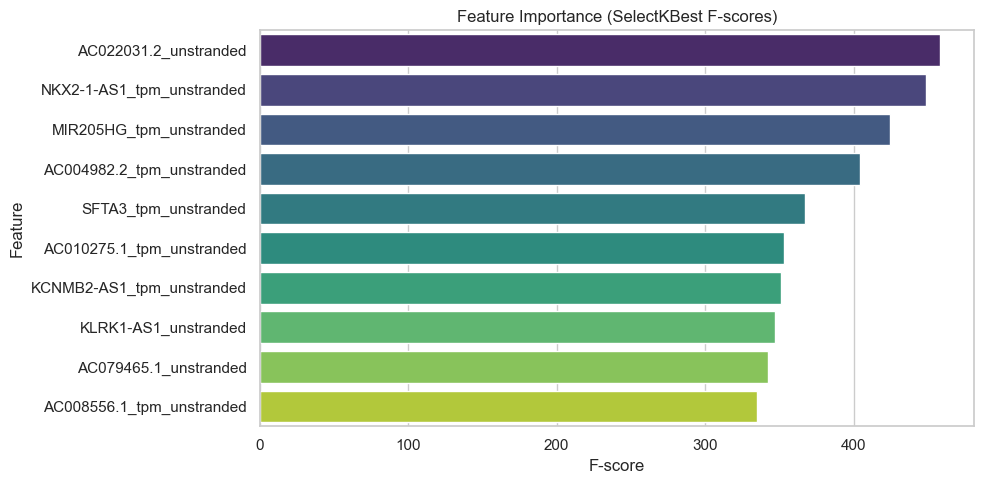

In [3297]:
# Convert to DataFrame and sort by score
featureScores: pd.DataFrame = pd.DataFrame({'Feature': X.columns, 'Score': selector.scores_})
featureScores = featureScores.sort_values(by='Score', ascending=False).head(kSelectBestThreshold)

# Plot the features and the corresponding f-scores into a bar chart
plt.figure(figsize=(10, 5))
sns.barplot(data=featureScores, x='Score', y='Feature', palette='viridis', hue='Feature', dodge=False)
plt.title('Feature Importance (SelectKBest F-scores)')
plt.xlabel('F-score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

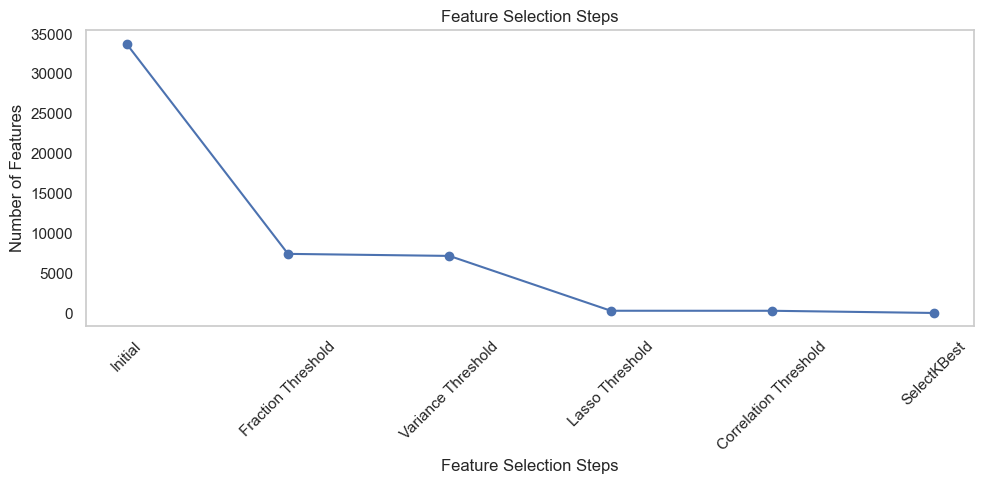

In [3298]:
# Plotting a line graph showing the feature selection steps
plt.figure(figsize=(10, 5))
plt.plot(list(featureSelectionSteps.keys()), list(featureSelectionSteps.values()), marker='o')
plt.title('Feature Selection Steps')
plt.xlabel('Feature Selection Steps')
plt.ylabel('Number of Features')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

#### 10. Model training

In [ ]:
import shap
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

# Random state for reproducibility
randomState: int = 462 
# Number of folds for cross-validation 
foldCount: int = 10

# The scores used for parameter tuning and evaluation
scoring: tuple[str] = ('accuracy', 'f1', 'recall',)

# Function to get the best parameters for a given model using GridSearchCV
def getBestParams(model, X: pd.DataFrame, y: pd.Series, paramGrid: dict | list[dict]) -> object:
    from sklearn.model_selection import GridSearchCV
    import warnings

    # Using GridSearchCV to find the best parameters
    gridSearch: GridSearchCV = GridSearchCV(model, paramGrid, cv=foldCount, scoring=scoring, n_jobs=-1, error_score=np.nan, refit='f1')
    
    # Suppressing warnings during the fitting process because some models may generate warnings during hyperparameter tuning
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        gridSearch.fit(X, y)

    # Displaying the best parameters found
    print(f"Best parameters for {model.__class__.__name__}: {gridSearch.best_params_}")

    # Return the best estimator
    return gridSearch.best_estimator_

# Function that evaluates any model's performance
def modelScore(model, X: pd.DataFrame, y: pd.Series) -> dict[str, object]:
    from sklearn.model_selection import StratifiedKFold
    from sklearn.metrics import roc_curve
    from sklearn.metrics import classification_report

    # Creating a StratifiedKFold object for cross-validation
    cv: StratifiedKFold = StratifiedKFold(n_splits=foldCount, shuffle=True, random_state=randomState)

    # Defining a results dict to collect results from each fold
    results: dict[str, object] = {
        'test_score': [],
        'roc_curves': [],
        'confusion_matrices': [],
        'feature_importances': [],
        'classification_reports': [],
        'shap_values': [],
        'average_feature_importance': None,
        'average_shap_values': None,
    }  

    # Manual cross-validation loop
    for trainIdx, testIdx in cv.split(X, y):
        # Creating the training and test data splits
        X_train, X_test = X.iloc[trainIdx], X.iloc[testIdx]
        y_train, y_test = y.iloc[trainIdx], y.iloc[testIdx]

        # Training the model based on the current fold
        model.fit(X_train, y_train)

        # Scoring the model on the test set
        results['test_score'].append(model.score(X_test, y_test))  

        # Storing the classification report
        results['classification_reports'].append(classification_report(y_test, model.predict(X_test), output_dict=True))

        # Predict probabilities for the positive class
        yScore = model.predict_proba(X_test)[:, 1]  # Positive class

        # Calculate ROC curve
        results['roc_curves'].append(roc_curve(y_test, yScore))

        # Calculate confusion matrix
        results['confusion_matrices'].append(pd.crosstab(y_test, model.predict(X_test), rownames=['Actual'], colnames=['Predicted']))
        
        # Check if the model has a feature_importances_ attribute
        hasFeatureImportances: bool = hasattr(model, 'feature_importances_')
        hasCoefficients: bool = hasattr(model, 'coef_')

        # If the model has feature importances, ro coefficients, or neither, we handle them accordingly
        data: list[float] | None = None
        if hasFeatureImportances:
            data = (model.feature_importances_, 'Importance')
        elif hasCoefficients:
            data = (model.coef_[0], 'Coefficient')

        # If the model has feature importances or coefficients, store them  
        if data is not None:
            results['feature_importances'].append(pd.DataFrame(data[0], index=X.columns, columns=[data[1]]).sort_values(data[1], ascending=False))      

        # Skipp the svm model if it does not have predict_proba
        if model.__class__.__name__ == 'SVC' and not hasattr(model, 'predict_proba'):
            print("SVM model does not support predict_proba, skipping SHAP values calculation.")
            continue
        # If the explainer is a TreeExplainer, it can handle models with predict_proba directly
        explainer: shap.Explainer = shap.Explainer(model, X_train)
        # For tree-based models, use the explainer directly
        if hasFeatureImportances:
            shapValues = explainer(X_test, check_additivity=False)
        else:
            shapValues = explainer(X_test)
    
        # Store the SHAP values
        results['shap_values'].append((shapValues, X_test))

    # Calculate the average confusion matrix
    results['average_confusion_matrix'] = sum(results['confusion_matrices']) / len(results['confusion_matrices'])

    # Calculate the average feature importances
    if len(results['feature_importances']) > 0:
        results['average_feature_importance'] = pd.concat(results['feature_importances']).groupby(level=0).mean()

    # Initialize new report
    avgReport: dict = {}
    reports: list = results['classification_reports']

    # Average per-class metrics
    for label in [key for key in reports[0].keys() if key not in ('accuracy',)]:
        avgReport[label] = {
            metric: np.mean([rep[label][metric] for rep in reports])
            for metric in reports[0][label]
        }

    # Adding the averaged classification report to results
    results['average_classification_report'] = avgReport        

    if len(results['shap_values']) > 0:
        # allShapValues = np.vstack(results['shap_values'])
        #np.mean(np.abs(allShapValues), axis=0)
        results['average_shap_values'] = results['shap_values'][0] 

    return results

# Function to retrieve the feature matrix (X) and target vector (y)
X, y = getDataXAndY(dataFrame, targetColumn)

# Training the Random Forest Classifier
rf = RandomForestClassifier(random_state=randomState)
rfParamGrid: dict[str: list] = {
    'n_estimators': [75, 100, 125],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 3, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False],
}
rfResults: dict[str: object] = modelScore(getBestParams(rf, X, y, rfParamGrid), X, y)

# Training a Logistic Regression model
logReg = LogisticRegression(max_iter=1000, random_state=randomState)
logRegParamGrid: list[dict[str: list]] = [
    {
        'C': [0.01, 0.1, 1, 10, 100],
        'penalty': ['l2'],
        'solver': ['lbfgs', 'liblinear'],
        'max_iter': [100, 200]
    },
    {
        'C': [0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2', 'elasticnet', 'none'],
        'solver': ['saga'],
        'max_iter': [100, 200]
    },

]
logRegResults: dict[str: object] = modelScore(getBestParams(logReg, X, y, logRegParamGrid), X, y)

# Train a Support Vector Machine (SVM) model
svm = SVC(kernel="linear", random_state=randomState, probability=True)
smvParamGrid: dict[str: list] = {
    'kernel': ['linear'],
    'C': [0.1, 1, 10, 100],
    'max_iter': [750, 1000, 1250],
    'class_weight': [None, 'balanced'],
}
svmResults: dict[str: object] = modelScore(getBestParams(svm, X, y, smvParamGrid), X, y)

Best parameters for RandomForestClassifier: {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 125}
Best parameters for LogisticRegression: {'C': 0.1, 'max_iter': 100, 'penalty': 'l1', 'solver': 'saga'}
Best parameters for SVC: {'C': 0.1, 'class_weight': None, 'kernel': 'linear', 'max_iter': 750}


#### 11. Model evaluation

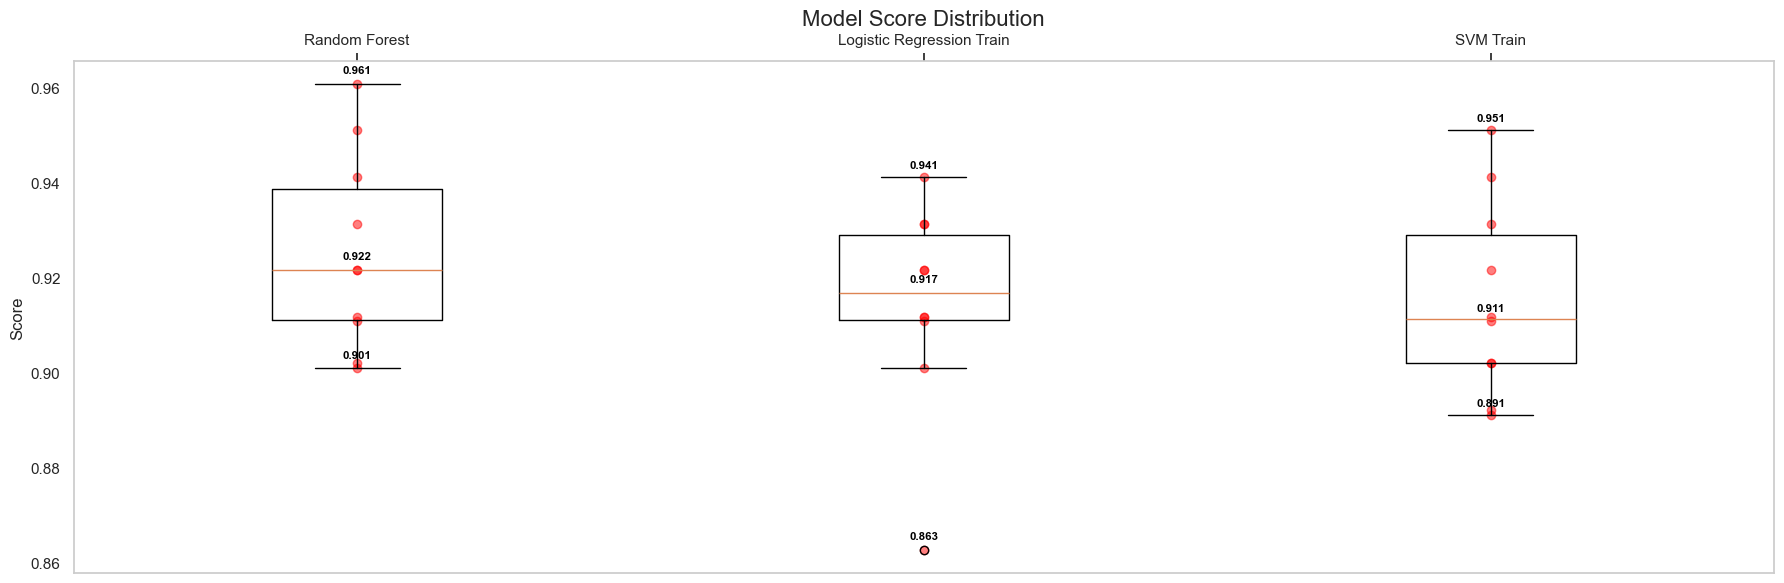

Random Forest Scores (0.9215686274509803): [0.9411764705882353, 0.9117647058823529, 0.9019607843137255, 0.9215686274509803, 0.9509803921568627, 0.9313725490196079, 0.9607843137254902, 0.9215686274509803, 0.900990099009901, 0.9108910891089109]
Logistic Regression Scores (0.9215686274509803): [0.9117647058823529, 0.8627450980392157, 0.9215686274509803, 0.9313725490196079, 0.9411764705882353, 0.9215686274509803, 0.9313725490196079, 0.9117647058823529, 0.900990099009901, 0.9108910891089109]
Support Vector Machine Scores(0.9215686274509803): [0.9117647058823529, 0.8921568627450981, 0.9019607843137255, 0.9313725490196079, 0.9509803921568627, 0.9215686274509803, 0.9411764705882353, 0.9019607843137255, 0.8910891089108911, 0.9108910891089109]


In [ ]:
from numpy import median

# Function that plots a dictionary of model scores
def boxPlotModelScores(results: dict[str: dict[str: object]]) -> None:
    keys: list[str] = list(results.keys())

    # Extracting the values from the scores dictionary
    scores: list[list[float]] = [score['test_score'] for score in list(results.values())] 

    # Plotting the box plot of model scores
    plt.figure(figsize=(18, 6))
    plt.boxplot(scores, vert=True, tick_labels=keys)
    plt.title('Model Score Distribution', fontsize=16)
    
    # Displaying all the datapoints recieved from the cross-validation scores
    for i, score in enumerate(scores):
        plt.scatter([i + 1] * len(score), score, color='red', alpha=0.5)

    # Function that plots textual values on top of the box plot
    def plotTexualValues(scores: list[float]):
        for i, value in enumerate(scores):
            value = round(value, 3)  # Rounding the value to 3 decimal places
            plt.text(i + 1, value + 0.002, value, horizontalalignment='center', size='x-small', color='w', weight='semibold', c="black")

    # Displaying the median values for each model on the box plot
    plotTexualValues([median(score) for score in scores])

    # Displaying the minimum and maximum values for each model on the box plot
    plotTexualValues([min(score) for score in scores])
    plotTexualValues([max(score) for score in scores])

    # Move x-axis ticks and label to the top
    ax = plt.gca()
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')

    plt.ylabel('Score')
    plt.grid()
    plt.tight_layout() 
    plt.show()    

# Creating a dictionary to hold the model scores for plotting
scores: dict[str: dict[str: object]] = {
    'Random Forest': rfResults,
    'Logistic Regression Train': logRegResults,
    'SVM Train': svmResults
}

boxPlotModelScores(scores)  

# Displaying the scores in text format to procide precise values
print(f"Random Forest Scores ({median(rfResults['test_score'])}): {rfResults['test_score']}")
print(f"Logistic Regression Scores ({median(rfResults['test_score'])}): {logRegResults['test_score']}")
print(f"Support Vector Machine Scores({median(rfResults['test_score'])}): {svmResults['test_score']}")

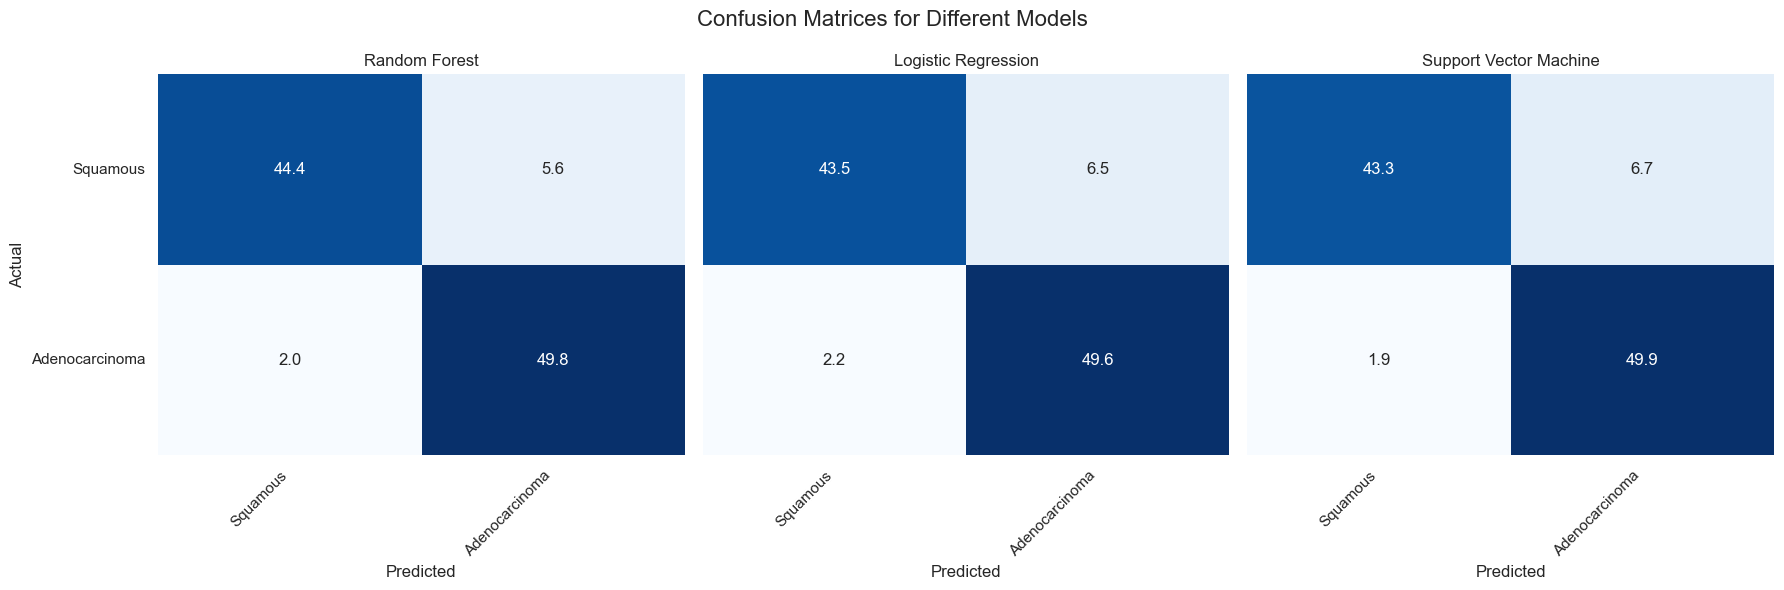

In [3301]:
from matplotlib.axes import Axes

# Function that displays any given confusion matrix on a specified axis
def plotConfusionMatrix(ax: Axes, results, name: str = 'Confusion Matrix', showYLabels: bool = False) -> None:
    averageConfusionMatrix: pd.DataFrame = results['average_confusion_matrix']

    # Plotting the confusion matrix using seaborn's heatmap
    sns.heatmap(averageConfusionMatrix, annot=True, fmt='.1f', cmap='Blues', cbar=False, ax=ax)
    ax.set_title(name)

    # Creating a list of ticks and making sure only the included categories are displayed
    ticks: list[str] = [categoryNameMap.get(int(label), label) for label in averageConfusionMatrix.index]

    # Displaying the ticks on both axes
    ax.set_xticklabels(ticks, rotation=45, ha='right')
    ax.set_yticklabels(ticks, rotation=0)

    # Used for fine control and less redundant labels
    if not showYLabels:
        ax.set_ylabel('')
        ax.set_yticklabels([])


# Creating a subplot figure with 3 columns for each model's confusion matrix
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Title for the entire figure
fig.suptitle('Confusion Matrices for Different Models', fontsize=16)

# Plotting the confusion matrices for each model
plotConfusionMatrix(axs[0], rfResults, 'Random Forest', True)
plotConfusionMatrix(axs[1], logRegResults, 'Logistic Regression')
plotConfusionMatrix(axs[2], svmResults, 'Support Vector Machine')

plt.tight_layout()
plt.show()

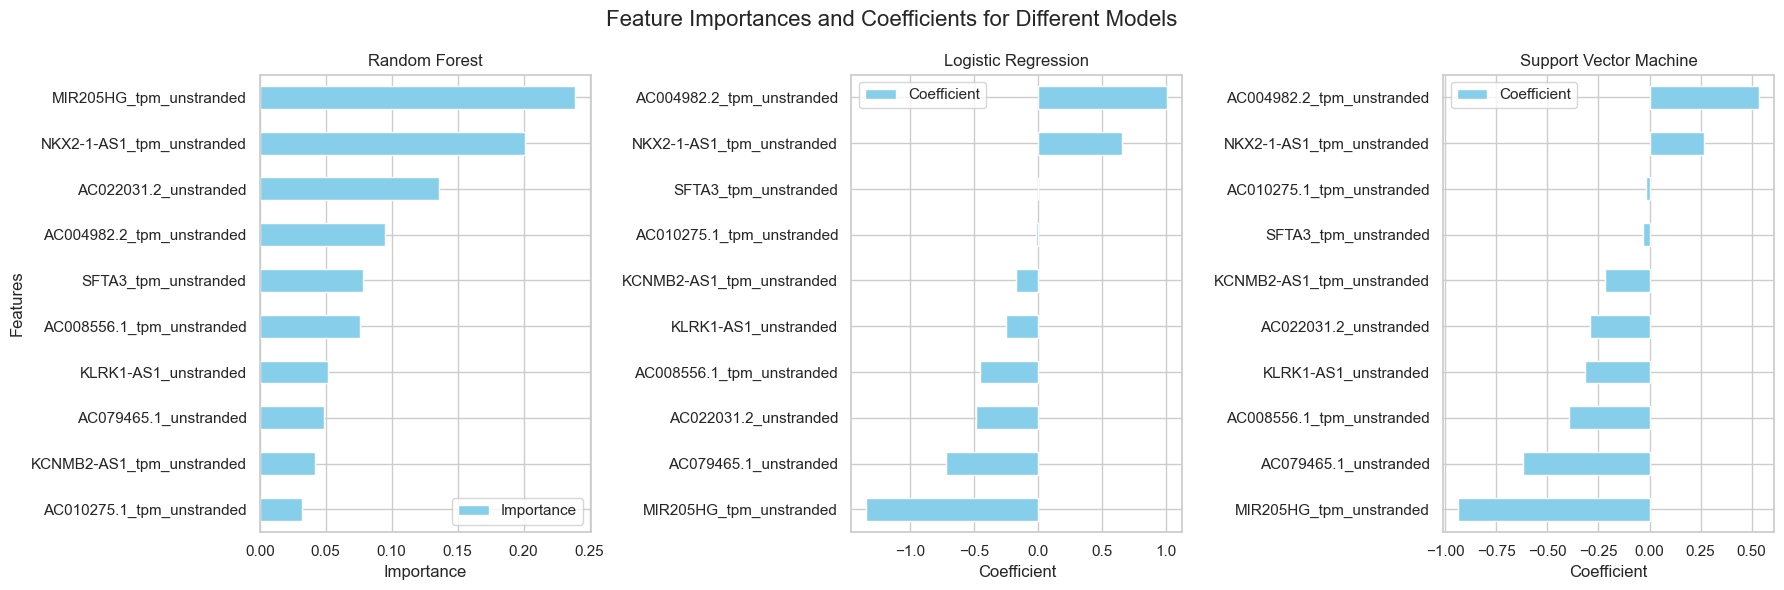

In [3302]:
# Function that displays a bar chart of the feature importances for a given model
def plotFeatureImportances(ax: Axes, results, name: str = 'Feature Importances', showYLabels: bool = False) -> None:
    # All plots will have a tile even if they are empty
    ax.set_title(name)

    # Checking if the model has supported for feature importances
    importances: list[float] | None = results['average_feature_importance']
    if importances is not None and not importances.empty:
        # Retrieving the unique column name for sorting
        columnName: str = importances.columns[0] if not importances.empty else 'Importance'

        # Sorting the importances by the specified column name
        importances = importances.sort_values(by=columnName, ascending=True)

        # Plotting the feature importances using the internal pandas plotting function
        importances.plot(kind='barh', ax=ax, color='skyblue')
       
        # Specificly setting the x-axis label to the column name
        ax.set_xlabel(columnName)

        # Used for fine control and less redundant labels
        if showYLabels:
            ax.set_ylabel('Features')
    else:
        # Schowing a message if there are no feature importances available
        ax.text(0.5, 0.5, 'No feature importances available', horizontalalignment='center', verticalalignment='center', fontsize=12)

        # Hiding the x and y axis ticks for the empty plot
        ax.set_xticks([])
        ax.set_yticks([])


# Creating a subplot figure with 3 columns for each model's feature importances
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Title for the entire figure
fig.suptitle('Feature Importances and Coefficients for Different Models', fontsize=16)

# Plotting the freature importances for each model
plotFeatureImportances(axs[0], rfResults, 'Random Forest', True)
plotFeatureImportances(axs[1], logRegResults, 'Logistic Regression')
plotFeatureImportances(axs[2], svmResults, 'Support Vector Machine') 

plt.tight_layout()
plt.show()

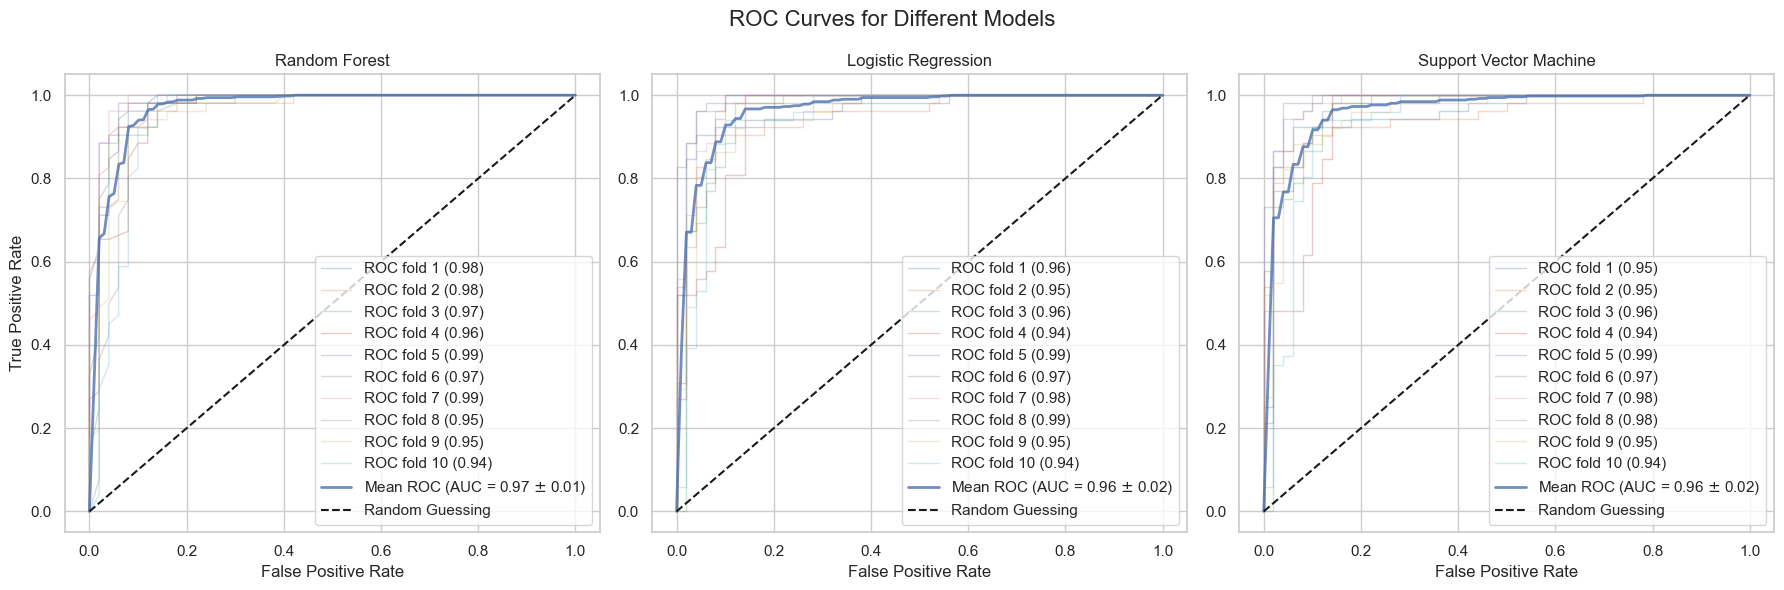

In [3303]:
def plotRocCurve(ax: Axes, results, name: str = 'ROC Curve', showYLabel: bool = False) -> None:
    from sklearn.metrics import auc
    import numpy as np

    # Keeping track of the tprs and aucs for plotting the mean ROC curve
    tprs: list = []
    aucs: list = []
    baseFpr = np.linspace(0, 1, 100)

    # Looping through each ROC curve to plot it
    for i, (fpr, tpr, _) in enumerate(results['roc_curves']):
        # Calculatiing the area under the curve (AUC) for statistical analysis
        aucValue: float = auc(fpr, tpr)

        # Plotting each ROC curve
        ax.plot(fpr, tpr, lw=1, alpha=0.3, label=f'ROC fold {i + 1} ({aucValue:.2f})')

        # Calculating the AUC for each ROC curve
        aucs.append(aucValue)
        tprInterp = np.interp(baseFpr, fpr, tpr)
        tprInterp[0] = 0.0
        tprs.append(tprInterp)  
    
    # Calculating the average ROC curve and AUC
    meanTpr: list = np.mean(tprs, axis=0)
    meanTpr[-1] = 1.0
    meanAuc: float = auc(baseFpr, meanTpr)
    stdUuc: float = np.std(aucs)

    # Plotting the average ROC curve
    ax.plot(baseFpr, meanTpr, color="b", label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (meanAuc, stdUuc), lw=2, alpha=0.8)

    # Plotting the example random guessing line
    ax.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
    ax.set_xlabel('False Positive Rate')

    # Used for fine control and less redundant labels
    if showYLabel:
        ax.set_ylabel('True Positive Rate')

    # Setting the x and y and placing the legend on an empty part of the plot    
    ax.set_title(name)
    ax.legend(loc='lower right')


# Creating a subplot figure with 3 columns for each model's ROC curve
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('ROC Curves for Different Models', fontsize=16)

# Plotting the ROC curves for each model
plotRocCurve(axs[0], rfResults, 'Random Forest', True)
plotRocCurve(axs[1], logRegResults, 'Logistic Regression')
plotRocCurve(axs[2], svmResults, 'Support Vector Machine')

# Showing the plot with tight layout
plt.tight_layout()
plt.show()

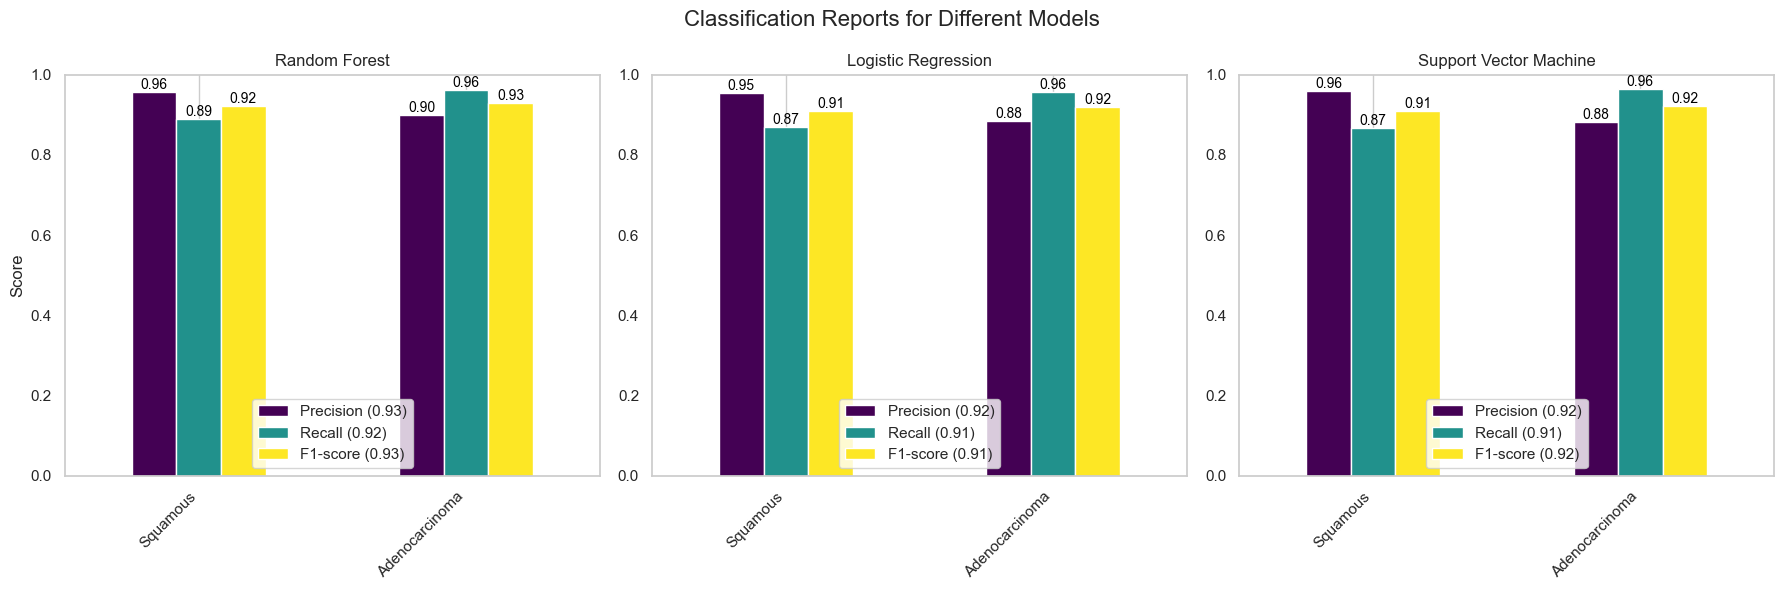

In [3304]:
def plotClassificationReport(ax: Axes, results, name: str = 'Classification Report', showYLabel: bool = False) -> None:
    import pandas as pd

    # This flattens the report into a DataFrame for easy plotting
    reportDataFrame: pd.DataFrame = pd.DataFrame(results['average_classification_report']).T

    # Keep only the desired metrics (ignore 'support')
    plotDataFrame: pd.DataFrame = reportDataFrame.drop(columns=['support'], errors='ignore')

    # Remove aggregate rows if you only want class-specific metrics
    classesOnly: pd.DataFrame = plotDataFrame.loc[~plotDataFrame.index.isin(['accuracy', 'macro avg', 'weighted avg'])]

    # Capitalizing each column name and appending the mean value for each class
    classesOnly.columns = [f"{column.capitalize()} ({classesOnly[column].mean():.2f})" for column in classesOnly.columns]

    # Plot using built-in pandas plotting function
    classesOnly.plot(kind='bar', colormap='viridis', ax=ax)
    ax.set_title(name)

    # Used for fine control and less redundant labels
    if showYLabel:
        ax.set_ylabel('Score')

    # Setting the y scale to be between 0 and 1 to match the classification report scores
    ax.set_ylim(0, 1)

    # Setting the grid to be vertical for better readability
    ax.grid(axis='y')

    # Adding text labels on top of the bars
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='bottom', fontsize=10, color='black')

    # Setting the x-ticks to show the the category names using the categoryNameMap
    ax.set_xticklabels([categoryNameMap.get(int(label), label) for label in classesOnly.index], rotation=45, ha='right')


# Creating a subplot figure with 3 columns for each model's classification report
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Classification Reports for Different Models', fontsize=16)

# Plotting the classification report for each model
plotClassificationReport(axs[0], rfResults, 'Random Forest', True)
plotClassificationReport(axs[1], logRegResults, 'Logistic Regression')
plotClassificationReport(axs[2], svmResults, 'Support Vector Machine')

# Showing the plot with tight layout
plt.tight_layout()
plt.show()

<Figure size 1800x600 with 0 Axes>

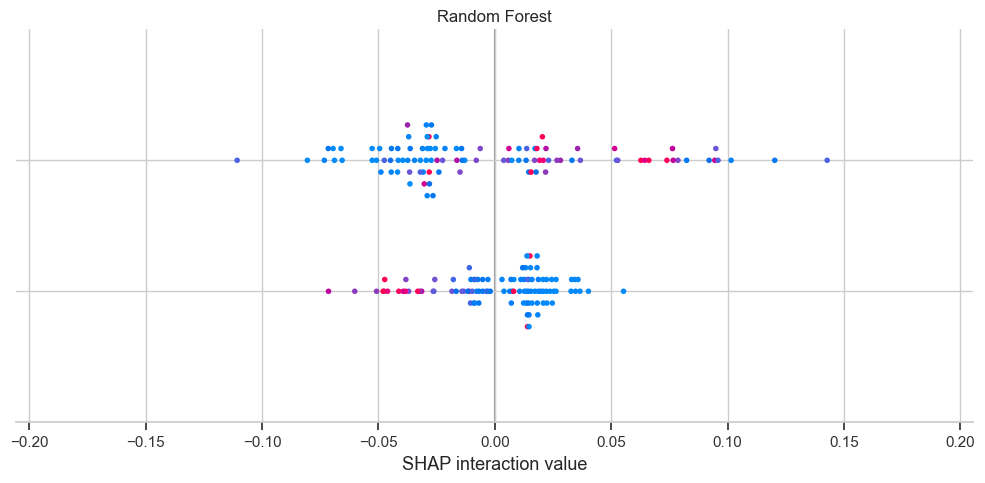

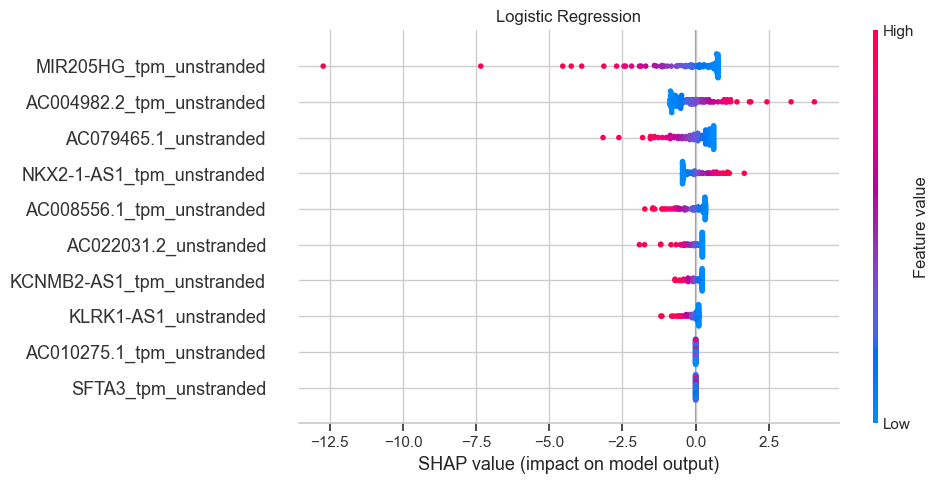

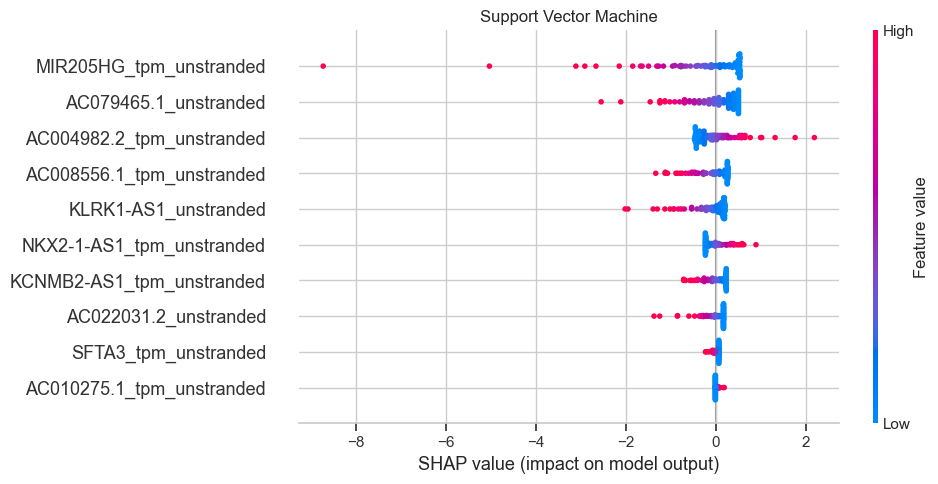

In [3305]:
# Function to plot SHAP values into a given Axes
def plotShapValues( results, name: str = 'SHAP Values') -> None:
    # Verifying that the model has SHAP values available
    avarageShap = results['average_shap_values']
    if avarageShap is None:
        return
    
    # Retrieving the SHAP values and the corresponding test set
    shapValues, X_test = avarageShap
   
    # Plotting the shap values into a dot plot
    shap.summary_plot(shapValues, X_test, plot_type='dot', plot_size=None, show=False)

    # Styling the plots to match in size and appearance
    plt.gcf().set_size_inches(10, 5)
    plt.title(name)
    plt.tight_layout()
    plt.show()

# subplots to hold the SHAP values for each model
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot each SHAP result into its own plot
plotShapValues(rfResults, 'Random Forest')
plotShapValues(logRegResults, 'Logistic Regression')
plotShapValues(svmResults, 'Support Vector Machine')